# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Luca Viano",
        'student_2': "Joachim Jacques Koerfer"}

sciper = {'student_1': 294418, 
          'student_2': 293815}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
conversations = getRawDataFromFile(datapath="personachat/", file="train_both_revised.txt")
conversations[:2]

[['hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .',
  'you must be very fast . hunting is one of my favorite hobbies .',
  'i am ! for my hobby i like to do canning or some whittling .',
  'i also remodel homes when i am not out bow hunting .',
  'that is neat . when i was in high school i placed 6th in 100m dash !',
  'that is awesome . do you have a favorite season or time of year ?',
  'i do not . but i do have a favorite meat since that is all i eat exclusively .',
  'what is your favorite meat to eat ?',
  'i would have to say its prime rib . do you have any favorite foods ?',
  'i like chicken or macaroni and cheese .',
  'do you have anything planned for today ? i think i am going to do some canning .',
  'i am going to watch football . what are you canning ?',
  'i think i will can some jam . do you also play footfall for fun ?',
  'if i have time outside of hunting and remodeling homes . which is not much !'],
 ['hi , how are you doin

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** According to Zipf's law applied to language, the frequency of any word is inversely proportional to its rank in the frequency table, so we should observe in the loglog plot a linear dependence. When looking at the corresponding plot, linear depence is observed in central part of the frequency table. The linear depence would be even better for larger data sets and a larger variety of sources of text (books, journals, ...).

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** There are 7080 unique words in the entire 'train_both_revised' data set.



In [4]:
"""
Count occurences of each word in all conversations
"""
list_words = [word for conversation in conversations for sentence in conversation for word in sentence.split(' ')]
dictionary = dict.fromkeys(list_words, 0)
for word in list_words:
    dictionary[word] += 1

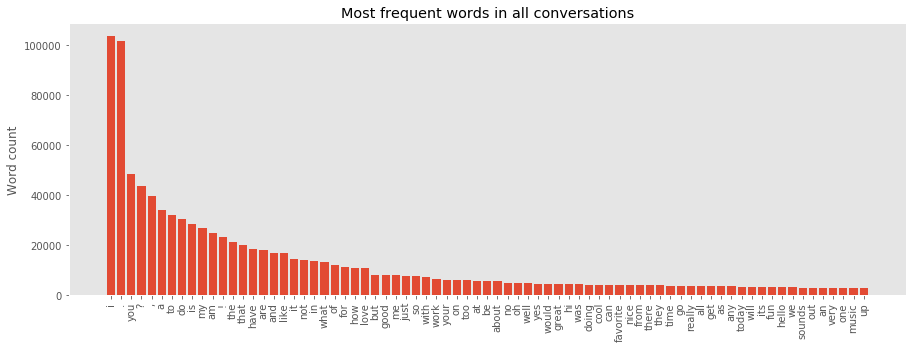

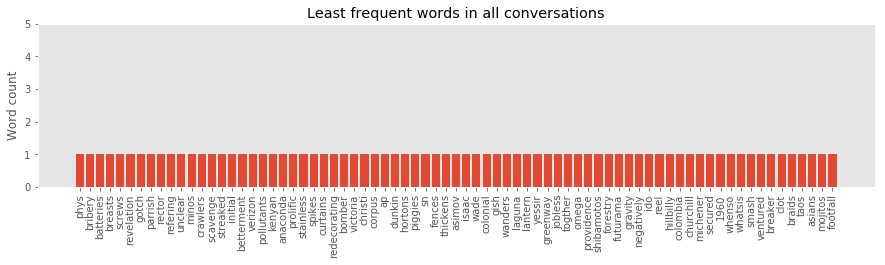

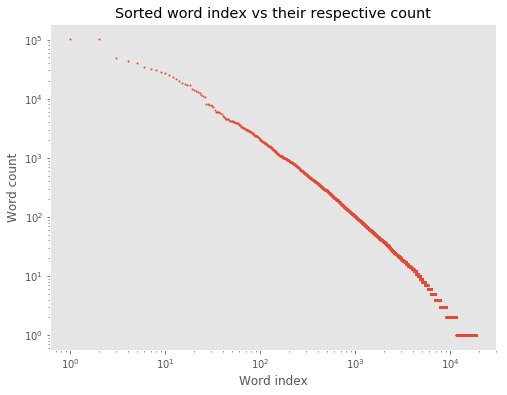

In [5]:
"""
Plot the 75 most and least frequent words in conversations and also word index vs respective count
"""
#Sort the dictionnary by value
sorted_dictionary = sorted(dictionary.items(), key=lambda x: x[1])[::-1]
values = [items[1] for items in sorted_dictionary]
keys = [items[0] for items in sorted_dictionary]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.title("Most frequent words in all conversations")
plt.ylabel("Word count")
plt.bar(keys[0:75], values[0:75])

plt.figure(figsize=(15,3))
plt.xticks(rotation=90)
plt.title("Least frequent words in all conversations")
plt.ylabel("Word count")
plt.ylim(0,5)
plt.bar(keys[-76:-1], values[-76:-1])

plt.figure(figsize=(8,6))
plt.title("Sorted word index vs their respective count")
plt.xlabel("Word index")
plt.ylabel("Word count")
plt.loglog(range(1, len(keys) + 1), values, '.', markersize=2)

In [5]:
print(len(conversations))
print(len(dictionary))

8938
18673


In [6]:
"""
Number of unique words
"""
values.count(1)

7080

### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: After the suppression procedure, the number of word went down from 18673 to 1077.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: There are 131424 sentences in the original dataset and 53067 sentences in the filtered data (with N=90)

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: During the learning, the association between rare words and other words is dominated by noise because there are not enough occurencies to allow to the net to learn in which context they are used. As a consequence, during the generalisation/generation phase they are likely to be used in an inappropriate manner.

In [7]:
def remove_rare_words(dictionary, N):
    new_dict = dict(dictionary)
    for key in dictionary.keys():
        if new_dict[key] <= N:
            del new_dict[key]
    return new_dict

def remove_rare_words_in_conversations(original_dictionary, conversations, N):
    """
    Removes all sentences containing word that are less frequent than N in all the data set.
    """
    num_sentences = 0
    filtered_conversations = []
    filtered_dictionary = remove_rare_words(original_dictionary, N)
    for conversation in conversations:
        filtered_conversations.append([])
        for sentence in conversation:
            keep_sentence = True
            words = sentence.split(' ')
            for word in words:
                if not word in filtered_dictionary:
                    keep_sentence = False
                    break
            if keep_sentence:
                num_sentences += 1
                filtered_conversations[-1].append(sentence)
        if len(filtered_conversations[-1]) == 0:
            del filtered_conversations[-1]
    return filtered_conversations, filtered_dictionary, num_sentences

In [8]:
"""
Filter sentences with rare words
"""
N = 90
original_num_sentences = len([sentence for conversation in conversations for sentence in conversation])
filtered_conversations, filtered_dictionary, num_sentences = remove_rare_words_in_conversations(dictionary, conversations, N)
print(original_num_sentences, num_sentences)
print(len(dictionary.keys()))
print(len(filtered_dictionary.keys()))

131424 53067
18673
1077


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

##### Tokenize sentences

In [9]:
"""
Transform the sentences into list of integers.
"""
index_dictionary = dict()
index_dictionary['PADD'] = 0
index_dictionary['START'] = 1
index_dictionary['END'] = 2
for i, key in enumerate(filtered_dictionary):
    index_dictionary[key] = i + 3

ANN_conversations = []
density_length = []
for conversation in filtered_conversations:
    ANN_conversations.append([])
    for sentence in conversation:
        sentence = sentence.split(' ')
        ANN_sentence = [index_dictionary['START']] + list(map(index_dictionary.get, sentence)) + [index_dictionary['END']]
        ANN_conversations[-1].append(ANN_sentence)
        density_length.append(len(ANN_sentence))

##### Violin plot

{'bodies': [<matplotlib.collections.PolyCollection at 0x2bf449875f8>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2bf44987710>,
 'cmins': <matplotlib.collections.LineCollection at 0x2bf44987048>,
 'cbars': <matplotlib.collections.LineCollection at 0x2bf44987da0>}

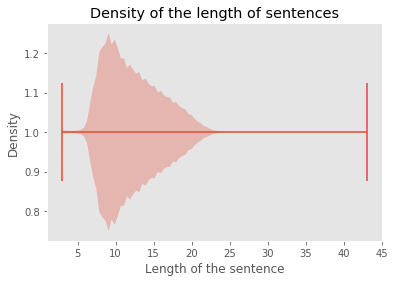

In [11]:
"""
Use violinplot to show the density of tokenized sentences length
"""        
plt.figure()
plt.title("Density of the length of sentences")
plt.xlabel("Length of the sentence")
plt.ylabel("Density")
plt.violinplot(density_length, vert=False)

##### PADD the sentences

In [10]:
"""
Padd the sentences to length 25 (looking at the figure above), with start and end
"""
maxlen = 25
filtered_tokenized_conv = []
for conversation in ANN_conversations:
    filtered_tokenized_conv.append(pad_sequences(conversation, maxlen=maxlen, value=0, padding='post'))

##### Recover the tokenized sentences

In [11]:
def recover_sentence_from_tokens(sentence, recover_dictionary, index_dictionary):
    s = sentence.tolist()
    if index_dictionary['START'] in s:
        s.remove(index_dictionary['START'])
    if index_dictionary['END'] in s:
        s.remove(index_dictionary['END'])
    s = [x for x in s if x != index_dictionary['PADD']]
    recovered_sentence = " ".join(list(map(recover_dictionary.get, s)))
    return recovered_sentence

In [13]:
"""
Try to recover the original sentence, using the filtered dictionary
"""
import random

for i in range(2):
    ind_conversation = random.randint(0, len(filtered_tokenized_conv) - 1)
    ind_sentence = random.randint(0, len(filtered_tokenized_conv[ind_conversation]) - 1)
    
    recover_dictionary = dict((v,k) for k,v in index_dictionary.items())
    sentence = filtered_tokenized_conv[ind_conversation][ind_sentence]

    recovered_sentence = recover_sentence_from_tokens(sentence, recover_dictionary, index_dictionary)

    print("Original :", filtered_conversations[ind_conversation][ind_sentence])
    print("Recovered : ", recovered_sentence)
    print()

Original : what do you do in your free time ?
Recovered :  what do you do in your free time ?

Original : i love the smell of it though
Recovered :  i love the smell of it though



### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [15]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([filtered_tokenized_conv, filtered_dictionary, index_dictionary], file)
    


In [11]:
import pickle
#load
with open("data.pkl", "rb") as file:
    [filtered_tokenized_conv, filtered_dictionary, index_dictionary] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** When the flag mask_zero is set to True, the embedding layer does not consider the number zero as a suitable input for the training. The numeric value 0 is associated to the artificial word 'PADD' that is thus ignored in the training process.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]
 
**Answer**
At each batch 64 sentences are considered as training input. They are represented by their tokenized vector without the last token since there is nothing that can be predicted after it. (i.e. the input has shape (batch_size, max_len - 1 )). At the output the net assigns by softmax a transistion probability to all the words in the dictionary. Thus the output taget is a one-hot encoding representation of the tokenized sentences without the first word. Indeed there are no previous words that can be used to predict it. It follows that Y has a shape equal to (batch_size, max_len - 1, dictionary_length).

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: LSTM is both the fastest learner and the best performing one. It reaches a validation accuracy about 0.4414.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: Overfitting can be detected in all the models noticing that the validation cross entropy curve starts increasing at approximately 15 epochs for all the three models. The main reason behind the observed overfitting are the small dimensions of the dataset and also there is no regularization.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Keeping more sentences in the dataset would increase the number of epochs after which overfitting is observed.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: To decrease overfitting, one could reduce the number of neurons for each layer so that the flexibility of the neural net is reduced.

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: One could use Early Stopping to stop the training phase when signs of overfitting are observed.

##### Build and train RNN, LSTM and GRU models

In [21]:
"""
For this part, the context of conversations in not useful. This part of the code puts all sentences in one big array.
"""
tokenized_sentences = [sentence for conversation in filtered_tokenized_conv for sentence in conversation]
filtered_sentences = [sentence for conversation in filtered_conversations for sentence in conversation]
tokens = index_dictionary

In [23]:
#Meta-parameters
embedding_size = 128
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [24]:
"""
Process input/output such that it can be understood by the net
"""
X = np.array(tokenized_sentences)[:dataset_cut,:]
T = np_utils.to_categorical(X, len(tokens))

In [25]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [38]:
"""
Define the model names. Execute also this cell for loading the pre-trained models.
"""
hidden_size = 64
num_hidden_layers = 1

model_names = ['LSTM_'+ str(num_hidden_layers) + "H_" + str(embedding_size) + "_" + str(hidden_size),
               'RNN_'+ str(num_hidden_layers) + "H_" + str(embedding_size) + "_" + str(hidden_size), 
               'GRU_'+ str(num_hidden_layers) + "H_" + str(embedding_size) + "_" + str(hidden_size)]

In [82]:
recurrent_fct_names = [LSTM, SimpleRNN, GRU]

for name, fct in zip(model_names, recurrent_fct_names):
    I[name] = Input(shape=(maxlen-1,), name="input") #Input
    
    E[name] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")(I[name]) #Embedding

    H[name] = fct(hidden_size, activation='relu', return_sequences = True)(E[name])#Hidden layer
    
    R[name] = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(H[name]) #Readout
    
    Y[name] = TimeDistributed(Dense(len(tokens), activation='softmax'))(R[name])#Output

    models[name] = Model(inputs = [I[name]], outputs = [Y[name]])
    models[name].compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['acc'])
    models[name].summary()

    print(X[:,:-1].shape, T[:,1:].shape)
    #logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]},
    logs[name] = models[name].fit(x = X[:dataset_cut,:-1], y = T[:dataset_cut,1:],
                                        epochs=epochs, 
                                        validation_split=validation_split, 
                                        batch_size=batch_size).history

    #save
    with open(name + "_log.pkl", "wb") as file:
        pickle.dump(logs[name], file)
    models[name].save(name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           138240    
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 24, 1080)          139320    
Total params: 335,288
Trainable params: 335,288
Non-trainable params: 0
_________________________________________________________________
(53066, 24) (53066, 24, 1080)
Train on 42452 samples, validate on 10613 samples
Epoch 1/32
42452/42452 [==============================] 

Epoch 31/32
42452/42452 [==============================] - 32s 754us/step - loss: 2.3340 - acc: 0.4621 - val_loss: 2.6786 - val_acc: 0.4380
Epoch 32/32
42452/42452 [==============================] - 32s 757us/step - loss: 2.3277 - acc: 0.4633 - val_loss: 2.6818 - val_acc: 0.4375


##### Learning curves (training / validation loss and accuracy)

In [27]:
def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)


Max val. acc. for LSTM : 0.4414685229846044
Max val. acc. for RNN : 0.43477338998962234
Max val. acc. for GRU : 0.43967566817148035


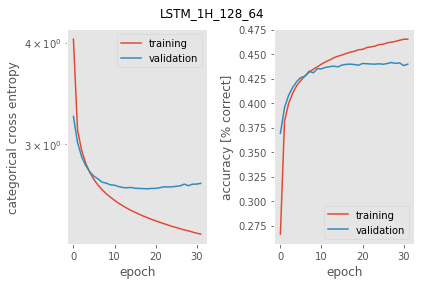

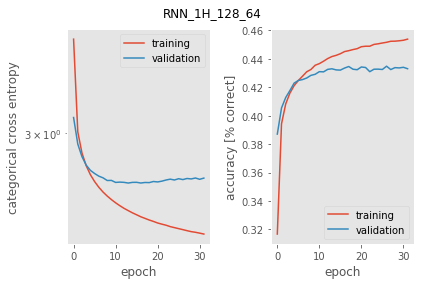

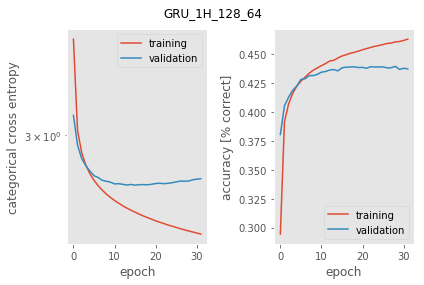

In [41]:
"""
Load and plot the pre-trained models. This cell requires the definition of the variable model_names, defined above.
"""
plot_titles = ["LSTM", "RNN", "GRU"]
logs = {}
models ={}

for name, title in zip(model_names, plot_titles):
    with open(name + "_log.pkl", "rb") as file:
        logs[name] = pickle.load(file)
        plot_history(logs[name],name)
    print("Max val. acc. for", title, ":", np.max(logs[name]['val_acc']))
    models[name] = load_model(name)
    

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** 

1) It can be seen that the highest the hidden size, the fastest is the learning process and the highest the best accuracy, i.e. the learning curve is steeper when the hidden size is bigger.

2) On the contrary two layers of 64 neurons perform worst than just one layer.

3) Overfitting comes into play earlier for more flexible models. Indeed GRU with 2 layers and GRU sigle layer with 64 neurons overfits about starts overfitting at epoch 7, 1 layer with 128 neurons at epoch 10 and, finally, 1 layer with 64 neurons at epoch 13. These values are determined according to the early stopping criterion.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**  EarlyStopping with the given parameters stops the training phase if for 2 consecutive epochs the validation accuracy does not increase of at least 0.001. The advantage is that it shorten the training time, the drawback is that one risks to stop training the model before reaching the optimal accuracy. Indeed looking at the GRU model with 64 layers it can be noticed that the validation accuracy slightly decreases about epoch 12 but then it increases again. 

**Question** What is your best model? Why? [1 pt]

**Answer** The best model is the one with a single GRU layer with 256 neurons. The highest number of neurons provides an additional flexibility that allows to the net to learn faster and with an highest accuracy. In addition, since it is trained applying EarlyStopping, overfitting it is avoided and the net can generalize well. 



##### Build and train network with earlystopping with 128 and 256 GRUs with early stopping

In [108]:
weights_embedding = models[model_names[0]].get_layer(index = 1).get_weights() #Get the weights of LSTM embedding layer

#GRU single layers
num_hidden_layers = 1

hidden_sizes = [128, 256]

for hidden_size in hidden_sizes:
    I = Input(shape=(maxlen-1,), name="input") #Input

    E = Embedding(len(tokens), embedding_size, weights = weights_embedding, mask_zero=True, name="embedding")(I) #Embedding


    H = GRU(hidden_size, activation='relu', return_sequences = True)(E)# Recurrent layer


    R = TimeDistributed(Dense(embedding_size, activation='relu'))(H)#Readout

    Y = TimeDistributed(Dense(len(tokens), activation='softmax'))(R)# Output

    name = "GRU_" + str(num_hidden_layers) + "H_" + str(embedding_size) + "_" + str(hidden_size)

    models[name] = Model(inputs = [I], outputs = [Y])
    models[name].compile(loss='categorical_crossentropy', 
                         optimizer=Adam(), 
                         metrics=['acc'])
    models[name].summary()

    logs[name] = models[name].fit(x = X[:dataset_cut,:-1], y = T[:dataset_cut,1:],
                                epochs=epochs, 
                                validation_split=validation_split, 
                                batch_size = batch_size,
                                callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)]).history

    #save
    with open(name + "_log.pkl", "wb") as file:
        pickle.dump(logs[name], file)
    models[name].save(name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           138240    
_________________________________________________________________
gru_9 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 24, 128)           16512     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 24, 1080)          139320    
Total params: 392,760
Trainable params: 392,760
Non-trainable params: 0
_________________________________________________________________
Train on 42452 samples, validate on 10613 samples
Epoch 1/32
42452/42452 [==============================] - 37s 876us/step - loss: 3.424

#### Build and train a model with 2 hidden layers of 64 GRUs with early stopping

In [109]:
#2 GRU layers
weights_embedding = models[model_names[0]].get_layer(index = 1).get_weights() #Get the weights of LSTM embedding layer
num_hidden_layers = 2
hidden_size = 64

I = Input(shape=(maxlen-1,), name="input")

E = Embedding(len(tokens), embedding_size, weights = weights_embedding, mask_zero=True, name="embedding")(I)

H1 = GRU(hidden_size, activation='relu', return_sequences = True)(E)#Recurrent layer
H2 = GRU(hidden_size, activation='relu', return_sequences = True)(H1)

R = TimeDistributed(Dense(embedding_size, activation='relu'))(H2)#Readout
Y = TimeDistributed(Dense(len(tokens), activation='softmax'))(R)#Output

name = "GRU_" + str(num_hidden_layers) + "H_" + str(embedding_size) + "_" + str(hidden_size)

models[name] = Model(inputs = [I], outputs = [Y])
models[name].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models[name].summary()

logs[name] = models[name].fit(x = X[:dataset_cut,:-1], y = T[:dataset_cut,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size = batch_size,
                                    callbacks = [EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2)]).history

#save
with open(name + "_log.pkl", "wb") as file:
    pickle.dump(logs[name], file)
models[name].save(name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 24)                0         
_________________________________________________________________
embedding (Embedding)        (None, 24, 128)           138240    
_________________________________________________________________
gru_11 (GRU)                 (None, 24, 64)            37056     
_________________________________________________________________
gru_12 (GRU)                 (None, 24, 64)            24768     
_________________________________________________________________
time_distributed_25 (TimeDis (None, 24, 128)           8320      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 24, 1080)          139320    
Total params: 347,704
Trainable params: 347,704
Non-trainable params: 0
_________________________________________________________________
Trai

##### Plot learning curves (training and validation loss and accuracy)

Best val. acc. for  GRU_1H_128_64 0.43967566817148035
Best val. acc. for  GRU_1H_128_128 0.4428990646490534
Best val. acc. for  GRU_1H_128_256 0.4445874492084004
Best val. acc. for  GRU_2H_128_64 0.4331949144464225


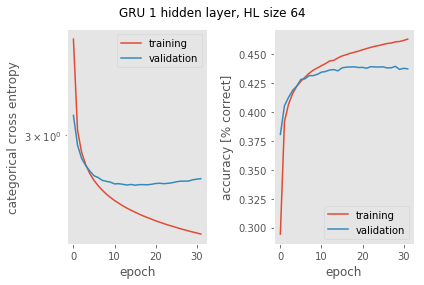

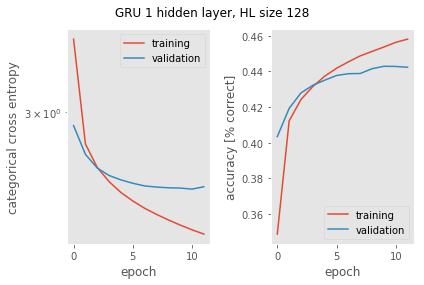

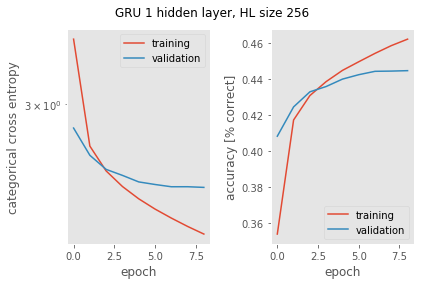

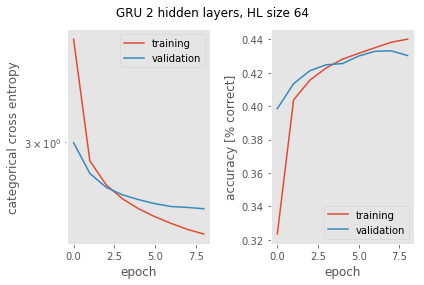

In [28]:
#load
names = ['GRU_1H_128_64','GRU_1H_128_128','GRU_1H_128_256','GRU_2H_128_64']
plot_titles = ["GRU 1 hidden layer, HL size 64", "GRU 1 hidden layer, HL size 128",
              "GRU 1 hidden layer, HL size 256", "GRU 2 hidden layers, HL size 64"]
hidden_layers_sizes = [64, 128, 256, 64]
for name, title, hidden_size in zip(names, plot_titles, hidden_layers_sizes):
    with open(name + "_log.pkl", "rb") as file:
        logs[name] = pickle.load(file)
        plot_history(logs[name],title)
    print("Best val. acc. for ", name, np.max(logs[name]['val_acc']))
    models[name] = load_model(name)
    

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer** The words are picked according to a multinomial distributions whose weights are the softmax function applied on the network output divided by the temperature. The higher the temperature, the more uniform is the distribution on all the word dictionary output.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer** For a temperature equal to zero, the output is the argmax on the output of the network. The corresponding probability distribution would be Kronecker delta centered at the argmax of the word.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**
It is a multinomial where the prob. of word $i$ is $$p_i = \frac{e^{\textrm{pred}_i}}{\sum_j e^{\textrm{pred}_j}} = \textrm{softmax} (pred_i)$$ where $pred_i$ is the output of the net at i-th neuron.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** For very high temperature all the exponential arguments go to zero and the multinomial distribution consequently tends to a uniform distribution.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**   At the first step the sentence to be generated is initialized having the 'START' in the first position and only 'PADD' in the others. It is passed as an input of the network and, then the next word is decided according to the provided sample function and it is added as second word in the generated sentence. It is used as input of the net for the next sentence and everything is repeated until one picks the word END or it reaches the maximum length.  

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer** Sometimes, there two similar ways to start or continue a sentence. For example in the plot with temperature 0.5, after a full stop '.', we observe that 'how' and 'i' and 'END' (and with lower prob. '.') have non-zero probability to be chosen. Here 'how' and 'i' are common ways to start a new grammatical sentence.

##### Generate sentences

In [29]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [60]:
def generate_sentence(recover_dictionary, tokens, temperature=1., name='GRU_1H_128_256', return_timesteps=False):
    """
    Generates a sentence using the sample fct and the best model
    """
    sentence = np.zeros((1,maxlen), dtype=int)
    sentence[0,0] = tokens['START']

    if return_timesteps:
        pred_matrix = np.zeros((maxlen - 1, len(tokens)))
    
    for i in range(0, maxlen - 2):
        pred = models[name].predict(sentence[:,:-1])[:,i+1,:].flatten()
        if return_timesteps:
            pred_matrix[i] = pred
            
        next_word = sample(pred, temperature)
        sentence[0,i+1] = next_word
        if next_word == tokens['END'] and not return_timesteps:
            break
    sentence = sentence.flatten()
    if return_timesteps:    
        return sentence, pred_matrix
    else:
        return recover_sentence_from_tokens(sentence, recover_dictionary, tokens)

In [62]:
def continue_sentence(recover_dictionary, tokens, sentence, temperature=1., name='GRU_1H_128_256'):
    """
    Continues a sentence from the proposed sentence
    """
    first_padd_ind = np.where(sentence.flatten() == tokens['PADD'])[0][0]
    for i in range(first_padd_ind, maxlen - 1):
        pred = models[name].predict(sentence[:,:-1])[:,i,:].flatten()
        next_word = sample(pred, temperature)
        sentence[0,i] = next_word
        if next_word == tokens['END']:
            break
    sentence = sentence.flatten() 
    
    return recover_sentence_from_tokens(sentence, recover_dictionary, tokens)

In [64]:
"""
Generate 10 sentences per temperature
"""
temperatures = [0., .25, .5, .75, 1., 1.5, 2.]
for temperature in temperatures:
    print("--- Temperature = ", temperature, "---", sep='')
    for i in range(10):
        sentence = generate_sentence(recover_dictionary, tokens, temperature=temperature)
        print("     ", sentence ,"\n")

--- Temperature = 0.0---
      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

      i am doing well . how are you ? 

--- Temperature = 0.25---
      i am doing well , thanks . how are you ? 

      i am good . i am just enjoying my day off . 

      i am doing well . how are you ? 

      i am doing well , how are you ? 

      i am doing well . how are you ? 

      i am doing well . just got back from the gym . 

      i am good thanks for asking 

      i am doing well . how about yourself ? 

      i am doing well . how are you ? 

      i am doing well , just got back from a run . 

--- Temperature = 0.5---
      do you have any hobbies ? 

      i do not think i am a guy as wel

##### Plots of the probabilities transitions at each timestep for different temperatures

C:\Users\Jokteur\Anaconda3\envs\cs456env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


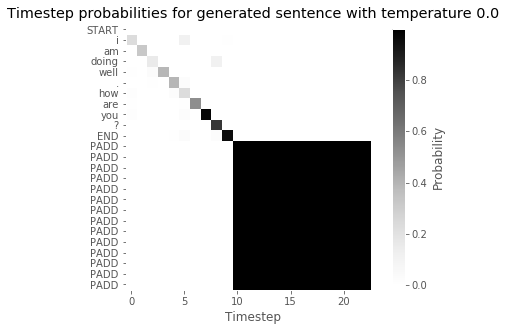

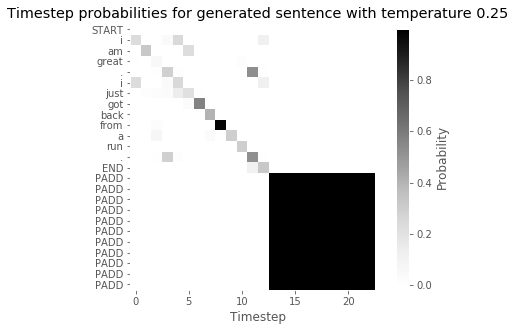

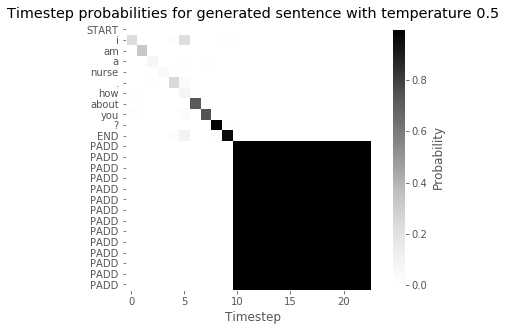

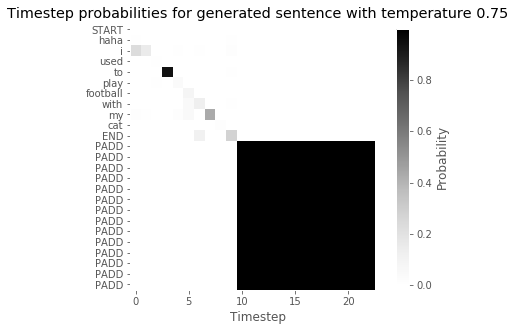

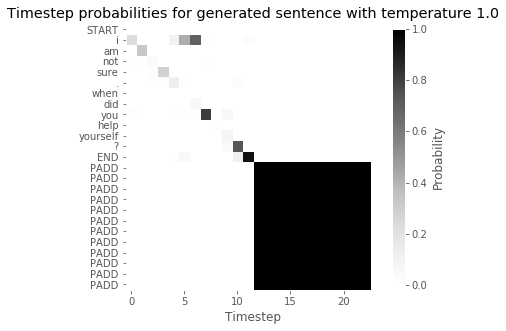

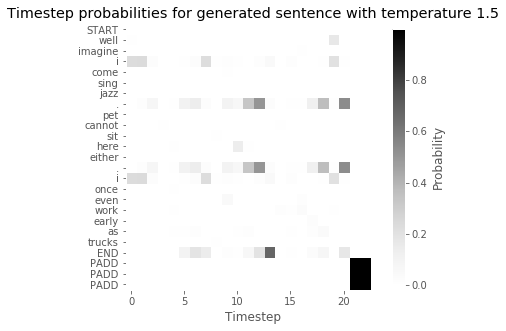

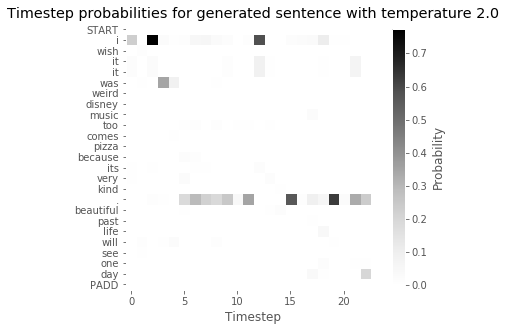

In [66]:
"""
For each temperature, show the probabilities given by the model for all words in the sentence at each timestep.
"""
name = 'GRU_1H_128_256'

for temperature in temperatures:
    #First generate a sentence a its prediction matrix
    sentence, pred_matrix = generate_sentence(recover_dictionary, tokens, temperature=temperature, name=name, return_timesteps=True)

    word_array = [recover_dictionary[word] for word in sentence]

    fig, ax = plt.subplots(figsize=(5,5))
    sc = ax.imshow(pred_matrix[:,sentence].T, 'Greys')
    ax.set_yticks(np.arange(len(word_array)))
    ax.set_yticklabels(word_array)
    plt.xlabel("Timestep")
    fig.colorbar(sc, label=r"Probability", fraction=0.046, pad=0.04)
    plt.title("Timestep probabilities for generated sentence with temperature " + str(temperature))


##### Continue sentence from a given sentence

In [74]:
"""
Continue sentence with prediction from a sentence with 4 words
"""
sentence1 = np.zeros((1, maxlen), dtype=int)
sentence1[0,0:4] = [tokens['START'], tokens['are'], tokens['you'], tokens['really']]
for i in range(10):
    print(continue_sentence(recover_dictionary, tokens, np.copy(sentence1), temperature=1.))
    
sentence2 = np.zeros((1, maxlen), dtype=int)
sentence2[0,0:3] = [tokens['START'], tokens['can'], tokens['you']]
for i in range(10):
    print(continue_sentence(recover_dictionary, tokens, np.copy(sentence2)))

are you really into that ?
are you really married ? i am so hungry right ?
are you really into animals ? i am in cali
are you really a little is work ?
are you really really ?
are you really smart or got ?
are you really in school ?
are you really happy there ? i enjoy being with my apartment .
are you really happy with your job ?
are you really a guy ? any children ?
can you all move to the ocean ?
can you go outside each night ?
can you run in something
can you come down a car ?
can you tell me about yourself ?
can you help ?
can you watch any tv and have museums ?
can you go or with them ?
can you read a book ?
can you keep this how i am instead ?


###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

Three very significant observed clusters are:

1) A cluster containing all the punctuation characters . ? , etc.

2) A cluster containing the modal verbs 'could, would, should ...'

3) A cluster containing the words 'cats, dogs, pets, animals ...'

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** Proximity of words with similar meanings implies a good performance of the model because one can thinks to the network output has a probability distribution over the embedded words space. If one assumes that the probability density is a smooth function, it follows that words close to each other will have a similar probability of being used. This can be useful when generating sentence, because two almost synonyms like 'pets' and 'dogs' will be used equally without changing to much the meaning of the sentence but allows generalization.

In [76]:
from sklearn.manifold import TSNE

In [77]:
"""
Build the model to visualize the word embedding
"""
best_model = 'GRU_1H_128_256'

weights_embedding = models[best_model].get_layer(index = 1).get_weights() #Get the weights of the best performing model
hidden_size = 64

I = Input(shape=(1,), name="input")

E = Embedding(len(tokens), embedding_size, weights = weights_embedding, mask_zero=True, name="embedding")(I)

name = "word_embedding"

models[name] = Model(inputs = [I], outputs = [E])
models[name].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models[name].summary()

models[name].save(name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 128)            138240    
Total params: 138,240
Trainable params: 138,240
Non-trainable params: 0
_________________________________________________________________


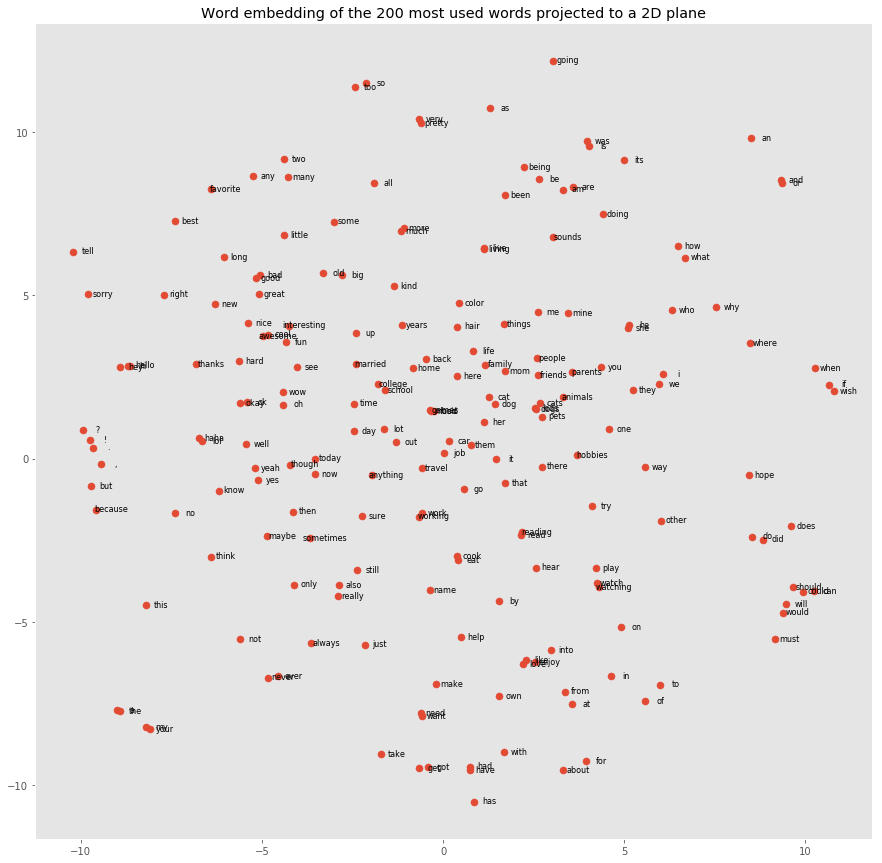

In [78]:
"""
Plot the word embedding projected to 2D of the 200 most used words
"""
sorted_filtered_dictionary = sorted(filtered_dictionary.items(), key=lambda x: x[1])[::-1]
keys = [items[0] for items in sorted_filtered_dictionary]
list_words = np.array([tokens[word] for word in keys[:200]])

prediction = models[name].predict(list_words)[:,0,:]

word_embedded = TSNE(n_components=2, random_state=2001).fit_transform(prediction)
plt.figure(figsize=(15,15))
word_x = word_embedded[:,0]
word_y = word_embedded[:,1]
plt.scatter(word_x, word_y, s=50)
plt.title("Word embedding of the 200 most used words projected to a 2D plane")

for i, coordinate in enumerate(word_embedded):

    x = coordinate[0]
    y = coordinate[1]
    label = keys[i]

    plt.annotate(label, (x,y), textcoords="offset points", xytext=(15,-2), ha='center', size=8)


## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

The generate answers are usually different from the real ones but they are probable. See the good example reported here. 

GOOD EXAMPLE

Q3: hello , i am doing well ! how is your day ?

   Real A : great , just came from a hike
   
   Chatbot: i am great ! just got off work from a movie .

BAD EXAMPLE

Q8 : ya meat is great , but i would never eat my cat .

   Real A : of course not ! what else do you do in your spare time ?
   
   Chatbot: i do not have any of them


**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer** The best results are atteined for a temperature equal to 0.5 since in this condition the highest softmax outputs of the networks are favoured.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** It would not be a good sign. It would provide clearly evidence of overfitting.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




##### Construct new dataset containing pairs of sentences, then tokenize and PADD the dataset

In [79]:
"""
Construct new data set where we only keep pairs of question/answer of sentence without rare words
"""
x_context = []
x_answer = []
for conv in conversations:    
    x_context += conv[0:-1]
    x_answer += conv[1:]
    
bad_indices = []
good_words = set(filtered_dictionary)
for i, context_answer in enumerate(zip(x_context, x_answer)):
    words_q = set(context_answer[0].split(' ') + context_answer[1].split(' '))
    if not words_q.issubset(good_words):
        bad_indices.append(i)

for i in reversed(bad_indices):
    del x_context[i]
    del x_answer[i]

In [80]:
"""
Tokenize, padd the sequences and add 'START' & 'END' to answers
"""
def tokenize_sentence(sentence, tokens):
    return list(map(tokens.get, sentence.split(' ')))

x_train_context = [tokenize_sentence(question, tokens) for question in x_context]
x_train_answer = [[tokens['START']] + tokenize_sentence(answer, tokens) + [tokens['END']] for answer in x_answer] 
x_train_context = pad_sequences(x_train_context, maxlen=maxlen, value=0, padding='post')
x_train_answer = pad_sequences(x_train_answer, maxlen=maxlen, value=0, padding='post')

In [81]:
"""
Process input/output such that it can be understood by the net
"""
T = np_utils.to_categorical(x_train_answer, len(tokens))

##### Build and train the dataset for the Chatbot

In [31]:
name='Chatbot'
hidden_size=64

#Load best model
best_model = 'GRU_1H_128_256'
models[best_model] = load_model(best_model)
    
weights_embedding = models[best_model].get_layer(index = 1).get_weights() #Get the weights of the best performing model


context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = Embedding(len(tokens), embedding_size, weights = weights_embedding, mask_zero=True, name="embedding")
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

models[name] = Model(inputs = [context, answer], outputs = [Y])
models[name].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models[name].summary()

logs[name] = models[name].fit(x = [x_train_context[:,:-2], x_train_answer[:,:-1]], y = T[:,1:],
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size = batch_size,
                                    callbacks = [EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2)]).history

#save
with open(name + "_log.pkl", "wb") as file:
    pickle.dump(logs[name], file)
models[name].save(name)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 24)           0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 23)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             138240      input_context[0][0]              
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[0][0]                  
__________

C:\Users\jokte\AppData\Local\conda\conda\envs\keras-gpu\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_3/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder_3/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [86]:
name = 'Chatbot'
with open(name + "_log.pkl", "rb") as file:
    logs[name] = pickle.load(file)
    models[name] = load_model(name)

##### Generate answer with the chatbot

In [96]:
def generate_answer(question, recover_dictionary, tokens, temperature=1., name='Chatbot'):
    """
    Generates an answer to the question using the sample fct and the Chatbot model
    """
    answer = np.zeros((1,maxlen), dtype=int)
    answer[0,0] = tokens['START']

    for i in range(0, maxlen - 2):
        pred = models[name].predict([question[:,:-2], answer[:,:-1]])[:,i,:].flatten()
            
        next_word = sample(pred, temperature)
        answer[0,i+1] = next_word
        if next_word == tokens['END']:
            break
    answer = answer.flatten()
    return recover_sentence_from_tokens(answer, recover_dictionary, tokens)

In [97]:
import random

for temperature in [0.5, 1.]:
    print("Current temperature = " + str(temperature))
    for i in range(10):
        rand_i = random.randint(0,len(x_context)-1)
        print("-- Q" + str(i+1) + " : " + x_context[rand_i])
        print("   Real A : " + x_answer[rand_i])
        question = x_train_context[rand_i]
        question.shape = (1,maxlen)
        print("   Chatbot: " + generate_answer(question, recover_dictionary, tokens, temperature=temperature) + "\n")

Current temperature = 0.5
-- Q1 : that is nice no garden i take it
   Real A : i love fresh garden vegetables
   Chatbot: what do you do for a living ?

-- Q2 : are you in school ? i am a college student .
   Real A : i am done with that .
   Chatbot: i am a student , i am a nurse .

-- Q3 : hello , i am doing well ! how is your day ?
   Real A : great , just came from a hike
   Chatbot: i am great ! just got off work from a movie .

-- Q4 : i am fine , movies is my hobby also
   Real A : oh , i like to sleep a lot when i am not at work .
   Chatbot: what do you do for a living ?

-- Q5 : how are you today ? what are your hobbies ?
   Real A : hi i am good . i really enjoy listening to rock , especially kid rock .
   Chatbot: i am good thanks for asking

-- Q6 : i mostly just love dogs . i have two as pets , and two more as their pets .
   Real A : i do not know , i have been this way since i was young .
   Chatbot: i like to read more than more to the beach

-- Q7 : hello there ! how 

#### Bonus question

In [98]:
import re

def ask_chatbot(question, temperature=1.):
    """
    Asks the chatbot a question and gives the answer from the chat bot. 
    """
    #Filter the question to have space between every word and punctuation
    regex = r'([\.,:\?!])'
    question = re.sub(regex, ' \g<0> ', question)
    words = list(filter(None, question.split(' ')))
    tokenized_sentence = np.array(tokenize_sentence(" ".join(words), tokens))
    
    #Find if there are word outside of filtered dictionary
    ind = np.argwhere(tokenized_sentence == None).flatten()
    if len(ind) > 0:
        missing_words = [words[i] for i in ind.tolist()]
        err_msg = "Error : the following words aren't understood by the Chatbot :\n" + " ".join(missing_words)
        return err_msg
    
    tokenized_sentence = pad_sequences([tokenized_sentence], maxlen=maxlen, value=0, padding='post')
    return generate_answer(tokenized_sentence, recover_dictionary, tokens, temperature=temperature, name='Chatbot')

In [100]:
"""
Test the chatbot with some generic questions
"""
print(ask_chatbot("hi"))
print(ask_chatbot("how are you ?"))
print(ask_chatbot("today i went to the shop and bought some water"))

hi ! how are you ?
i am doing enjoying a day .
sounds like a good idea . do you enjoy a big house


In [102]:
"""
Make the chatbot talk with itself
"""
question = "hello there"
for i in range(10):
    if i % 2 == 0:
        print("Bob : " + question)
    else:
        print("Alice : " + question) 
    question = ask_chatbot(question, 0.75)

Bob : hello there
Alice : hi , how are you ?
Bob : i am doing great . just hanging out at a local zoo .
Alice : do you like video games
Bob : yes i do . i cannot wait with me and all any siblings .
Alice : i am not into art . i just love to swim all time .
Bob : oh really ? i like to play music
Alice : do you work in school ?
Bob : i am an accountant with school . what about you ?
Alice : i am a big fan of family . we have a lab or left .
